In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Getting the MNIST data and storing it in ./MNIST_data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Hyperparameters
batch_size = 32 # Number of images to run at each batch
learning_rate = 0.03 # Learning rate for optimizer
logdir = './logs/dcgan_mnist/' # Logdir for tensorboard summaries
num_adversarial_iter = 1000000 # Number of epochs for the adversarial training
num_discriminator_iter = 1000 # Number of epochs to pretrain the discriminator
pkeep = 0.75 # Probability with which to keep nodes
print_all = False # Print all tensor names and shapes

In [4]:
# Helper functions to create convolutional and fully connected layers with tensorboard summaries

def conv_layer(input, kernel_size, channels_in, channels_out, stride, name, reuse_variables=None):
    with tf.variable_scope(name, reuse=reuse_variables):
        # Defining the graph of the operation
        w = tf.get_variable('weights', [kernel_size, kernel_size, channels_in, channels_out], 
                            initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable('biases', [channels_out], initializer=tf.truncated_normal_initializer(stddev=0.01))      
        conv = tf.nn.conv2d(input, w, strides=[1, stride, stride, 1], padding="SAME")      
        act = tf.nn.elu(conv + b, name='activation') 
        
        # Creating summaries for Tensorboard
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        
        # Printing operation names and shapes for debugging
        global print_all
        if print_all:
            print(w.name, w.shape)            
            print(b.name, b.shape)
            print(conv.name, conv.shape)
            print(act.name, act.shape)
            
        return act

def fc_layer(input, size_in, size_out, name, activation, reuse_variables=None):
    with tf.variable_scope(name, reuse=reuse_variables):
        # Defining the graph of the operation
        w = tf.get_variable('weights', [size_in, size_out], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable('biases', [size_out], initializer=tf.truncated_normal_initializer(stddev=0.01)) 
        logit = tf.matmul(input, w) + b
        
        # Creating summaries for Tensorboard
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        
        # Printing operation names and shapes for debugging
        global print_all
        if print_all:
            print(w.name, w.shape)            
            print(b.name, b.shape)
            print(logit.name, logit.shape)
        
        # Covering the different cases needed
        if activation == 'linear':
            tf.summary.histogram("activations", logit)
            return logit
        elif activation == 'elu':
            act = tf.nn.elu(logit, name='activation')
            tf.summary.histogram("activations", act)
            if print_all:
                   print(act.name, act.shape)
                    
            return act
    
def deconv_layer(input, kernel_size, channels_in, channels_out, stride, name, activation, reuse_variables=None):
    input_shape = input.get_shape().as_list()
    with tf.variable_scope(name, reuse=reuse_variables):
        # Defining the graph of the operation
        w = tf.get_variable('weights', [kernel_size, kernel_size, channels_out, channels_in], 
                            initializer=tf.truncated_normal_initializer(stddev=0.02))
        b = tf.get_variable('biases', [channels_out], initializer=tf.truncated_normal_initializer(stddev=0.01))
        conv = tf.nn.conv2d_transpose(input, w, 
                                      output_shape=[input_shape[0], input_shape[1]*stride, input_shape[2]*stride, channels_out], 
                                      strides=[1, stride, stride, 1], padding="SAME")
        
        # Creating summaries for Tensorboard
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        
        # Printing operation names and shapes for debugging
        global print_all
        if print_all:
            print(w.name, w.shape)
            print(b.name, b.shape)
            print(conv.name, conv.shape)
            
        # Covering the different cases needed
        if activation == 'elu':
            act = tf.nn.elu(conv + b, name='activation')
            if print_all:
                print(act.name, act.shape)
            tf.summary.histogram("activations", act)
            return act
        elif activation == 'sigmoid':
            act = tf.nn.sigmoid(conv + b, name='activation')
            if print_all:
                print(act.name, act.shape)
            tf.summary.histogram("activations", act)
            return act

In [5]:
# Defining the discriminator

# input: [batch_size, 28, 28, 1]
# output: [batch_size, 1]

# 2 convolutional layers: input_shape = [-1, 28, 28, 1], output_shape = [-1, 7, 7, 64]
# - Conv1: 32 5x5 filters, stride 2x2, padding = same, input_shape = [-1, 28, 28, 1]
#   - weights: shape = [5, 5, 1, 32], initializer = tf.truncated_normal_initializer(stddev=0.02)
#   - bias: shape = [32], initializer = tf.truncated_normal_initializer(stddev=0.01)
#   - strides: [1, 2, 2, 1]
#   - activation: tf.nn.elu
# - Conv2: 64 5x5 filters, stride 2x2, padding = same, input_shape = [-1, 14, 14, 64]
#   - weights: shape = [5, 5, 32, 64], initializer = tf.truncated_normal_initializer(stddev=0.02)
#   - bias: shape = [64], initializer = tf.truncated_normal_initializer(stddev=0.01)
#   - strides: [1, 2, 2, 1]
#   - activation: tf.nn.elu
# Reshape into vectors: input_shape = [-1, 7, 7, 64], output_shape = [-1, 7 * 7 * 64]
# 3 fully connected layers: input_shape = [-1, 3136], output_shape = [-1, 1]
# - FC1: input_shape = [-1, 3136]
#   - weights: shape = [3136, 1024], initializer = tf.truncated_normal_initializer(stddev=0.02)
#   - bias: shape = [1024], initializer = tf.truncated_normal_initializer(stddev=0.01)
#   - activation: tf.nn.elu
# - FC2: input_shape = [-1, 1024]
#   - weights: shape = [1024, 128], initializer = tf.truncated_normal_initializer(stddev=0.02)
#   - bias: shape = [128], initializer = tf.truncated_normal_initializer(stddev=0.01)
#   - activation: tf.nn.elu
# - FC3: input_shape = [-1, 128]
#   - weights: shape = [128, 1], initializer = tf.truncated_normal_initializer(stddev=0.02)
#   - bias: shape = [1], initializer = tf.truncated_normal_initializer(stddev=0.01)
#   - activation: linear

# Loss: tf.sigmoid_cross_entropy_with_logits
# Optimizer: tf.train.AdamOptimizer

def discriminator(images, reuse_variables=None):
    if not reuse_variables:
        print('Initializing Discriminator')
    else:
        print('Reusing Discriminator')
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables):
        d_conv_1 = conv_layer(input=images, kernel_size=5, channels_in=1, channels_out= 32, stride=2,
                                    name='discriminator_conv_1', reuse_variables=reuse_variables)
        d_conv_2 = conv_layer(input=d_conv_1, kernel_size=5, channels_in=32, channels_out= 64, stride=2,
                                    name='discriminator_conv_2', reuse_variables=reuse_variables)
        flattened = tf.reshape(d_conv_2, [-1, 7*7*64])
        d_fc_1 = fc_layer(input=flattened, size_in=7*7*64, size_out=1024, activation='elu', name='discriminator_fc_1',
                          reuse_variables=reuse_variables)
        d_fc_2 = fc_layer(input=d_fc_1, size_in=1024, size_out=128, activation='elu', name='discriminator_fc_2',
                          reuse_variables=reuse_variables)
        d_fc_3 = fc_layer(input=d_fc_2, size_in=128, size_out=1, activation='linear', name='discriminator_fc_3',
                          reuse_variables=reuse_variables)
        return d_fc_3

In [6]:
# Defining the generator

# input: [batch_size, 128]
# output: [batch_size, 28, 28, 1]

# 2 fully connected layers: input_shape = [-1, 128], output_shape = [-1, 7 * 7 * 64]
# - FC1: input_shape = [-1, 128], output_shape = [-1, 1024]
#   - weights: shape = [128, 1024], initializer = tf.truncated_normal_initializer(stddev=0.02)
#   - bias: shape = [1024], initializer = tf.truncated_normal_initializer(stddev=0.01)
#   - activation: tf.nn.elu
# - FC2: input_shape = [-1, 1024], output_shape = [-1, 7 * 7 * 128]
#   - weights: shape = [1024, 7 * 7 * 64], initializer = tf.truncated_normal_initializer(stddev=0.02)
#   - bias: shape = [7 * 7 * 64], initializer = tf.truncated_normal_initializer(stddev=0.01)
#   - activation: tf.nn.elu
# Reshape data: input_shape = [-1,7*7*64] output_shape = [-1, 7, 7, 64]
# 2 transpose convolution layers: input_shape = [-1, 7, 7, 64], output_shape = [-1, 28, 28, 1]
# - Transpose_Conv1: input_shape = [-1, 7, 7, 64], output_shape = [-1, 14, 14, 32]
#   - weights: shape = [5, 5, 64, 32], initializer = tf.truncated_normal_initializer(stddev=0.02)
#   - bias: shape = [64], initializer = tf.truncated_normal_initializer(stddev=0.01)
#   - strides: [1, 2, 2, 1]
#   - activation: tf.nn.elu
# - Transpose_Conv2: input_shape = [-1, 14, 14, 32], output_shape = [-1, 28, 28, 1]
#   - weights: shape = [5, 5, 32, 1], initializer = tf.truncated_normal_initializer(stddev=0.02)
#   - bias: shape = [1], initializer = tf.truncated_normal_initializer(stddev=0.01)
#   - strides: [1, 2, 2, 1]
#   - activation: tf.nn.sigmoid

# Loss: tf.sigmoid_cross_entropy_with_logits
# Optimizer: tf.train.AdamOptimizer

def generator(z, reuse_variables=None):
    if not reuse_variables:
        print('Initializing Generator')
    else:
        print('Reusing Generator')
    with tf.variable_scope(tf.get_variable_scope()):
        g_fc_1 = fc_layer(input=z, size_in=128, size_out=1024, activation='elu', name='generator_fc_1', 
                          reuse_variables=reuse_variables)
        g_fc_2 = fc_layer(input=g_fc_1, size_in=1024, size_out=7*7*64, activation='elu', name='generator_fc_2', 
                          reuse_variables=reuse_variables)
        reshaped = tf.reshape(g_fc_2, [-1, 7, 7, 64])
        g_deconv_1 = deconv_layer(input=reshaped, kernel_size=5, channels_in=64, channels_out= 32, stride=2,
                                        name='generator_deconv_1', activation='elu', reuse_variables=reuse_variables)
        g_deconv_2 = deconv_layer(input=g_deconv_1, kernel_size=5, channels_in=32, channels_out= 1, stride=2,
                                        name='generator_deconv_2', activation='sigmoid', reuse_variables=reuse_variables)
        return g_deconv_2

In [7]:
# Testing that the graphs work as intended
# Using a constant zero vector of the correct shape to get the resulting tensors and their shapes

#with print_all = True:
#    const = tf.constant(0, shape=[28*28, 128], dtype=tf.float32)
#    gen = generator(const)
#    reshaped_const = tf.reshape(const, [-1, 28, 28, 1])
#    discrim1 = discriminator(reshaped_const)
#    discrim2 = discriminator(reshaped_const, True)


# Print the nodes in the graph
#[n.name for n in tf.get_default_graph().as_graph_def().node]

In [8]:
# Defining the graphs, loss, optimizers, and summaries
tf.reset_default_graph()

# Creating placeholders for input to graph
z_placeholder = tf.placeholder(tf.float32, [batch_size, 128], name = 'z_placeholder')
images_placeholder = tf.placeholder(tf.float32, [batch_size, 784], name = 'images_placeholder')
images_reshaped = tf.reshape(images_placeholder, [-1, 28, 28, 1])
tf.summary.image('Input_images', images_reshaped, 6)

# Initializing Generator and Discriminators
Generator = generator(z_placeholder)
Discriminator_real = discriminator(images_reshaped)
Discriminator_fake = discriminator(Generator, reuse_variables=True)

# Defining loss functions for networks
with tf.name_scope('Cross_Entropy'):
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Discriminator_real, 
                                                                         labels=tf.zeros_like(Discriminator_real)))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Discriminator_fake, 
                                                                         labels=tf.ones_like(Discriminator_fake)))
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Discriminator_fake, 
                                                                    labels=tf.zeros_like(Discriminator_fake)))
    tf.summary.scalar('D_loss_real', D_loss_real)
    tf.summary.scalar('D_loss_fake', D_loss_fake)
    tf.summary.scalar('G_loss', G_loss)

# Getting the variables for each network to update only certain weights during each optimization
tvars = tf.trainable_variables()
D_vars = [var for var in tvars if 'discriminator_' in var.name]
G_vars = [var for var in tvars if 'generator_' in var.name]

# Defining the optimizer (Adam adaptive learning rate and momemtum optimizer)
with tf.name_scope('Train'):
    D_train_real = tf.train.AdamOptimizer(learning_rate).minimize(D_loss_real, var_list=D_vars)
    D_train_fake = tf.train.AdamOptimizer(learning_rate).minimize(D_loss_fake, var_list=D_vars)
    G_train = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=G_vars)
                                                                  
# Defining graph for generating a sample image
z_sample = tf.placeholder(dtype = tf.float32, shape = [6, 128], name='z_sample')
sample_images = generator(z_sample, True)
tf.summary.image('Generated_images', sample_images, 6)

Initializing Generator
Initializing Discriminator
Reusing Discriminator
Reusing Generator


<tf.Tensor 'Generated_images:0' shape=() dtype=string>

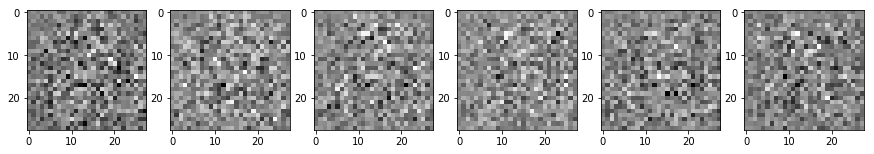

In [9]:
# Define Tensorflow session and intialize variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Summary merging and writing
saver = tf.train.Saver()
summ = tf.summary.merge_all()
writer = tf.summary.FileWriter(logdir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/")
writer.add_graph(sess.graph)
saver = tf.train.Saver()

# Generate a sample image before training
image = sess.run(sample_images, feed_dict={z_sample: np.random.normal(-1,1,[6,128])})
fig, ax = plt.subplots(1, 6, figsize = (15, 24))
for i, a in enumerate(ax):
    a.imshow(image[i].squeeze(), cmap='gray_r') # Squeeze the output of the generator down to two dimensions
plt.show()

In [10]:
# Pretraining for discriminator
for i in range(num_discriminator_iter):
    image_batch = mnist.train.next_batch(batch_size)
    z_input = np.random.normal(-1, 1, [batch_size, 128])
    
    sess.run([D_train_real, D_train_fake], feed_dict={images_placeholder: image_batch[0],
                                                      z_placeholder: z_input})
    if i % 100 == 0:
        image_batch_val = mnist.train.next_batch(batch_size)
        z_val = np.random.normal(-1, 1, [batch_size, 128])
        
        real_loss, fake_loss = sess.run([D_loss_real, D_loss_fake], feed_dict={images_placeholder: image_batch_val[0],
                                                                                z_placeholder: z_val})
        print(i, real_loss, fake_loss)

0 0.0 5412.8
100 2.69278e-05 3.90774
200 8.90635e-08 3.91586e-06
300 1.14839e-08 3.50839e-06
400 7.74192e-08 3.14437e-06
500 3.0109e-08 2.80425e-06
600 1.69351e-07 2.50705e-06
700 3.02123e-08 2.23975e-06
800 1.38751e-08 2.01621e-06
900 1.12225e-07 1.79915e-06


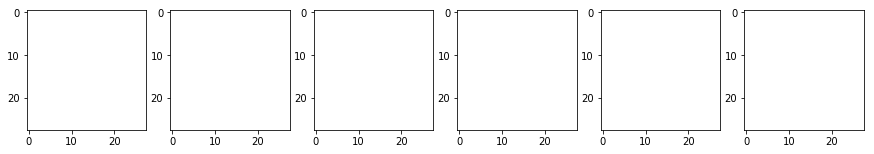

KeyboardInterrupt: 

In [12]:
# Train networks together

for i in range(num_adversarial_iter):
    image_batch = mnist.train.next_batch(batch_size)
    z_input = np.random.normal(-1, 1, [batch_size, 128])
    
    sess.run([D_train_real, D_train_fake, G_train], feed_dict={images_placeholder: image_batch[0],
                                                               z_placeholder: z_input})
    
    if i%10 == 0:
        z_val = np.random.normal(-1, 1, [batch_size, 128])
        image_batch_val = mnist.train.next_batch(batch_size)
        z_summary = np.random.normal(-1, 1, [6, 128])
        s = sess.run(summ, {z_placeholder: z_val, images_placeholder: image_batch_val[0], z_sample: z_summary})
        writer.add_summary(s, i)
        if i%10000 == 0:
            image = sess.run(sample_images, feed_dict={z_sample: z_summary})
            plt.close()
            fig, ax = plt.subplots(1, 6, figsize = (15, 24))
            for i, a in enumerate(ax):
                a.imshow(image[i].squeeze(), cmap='gray_r') # Squeeze the output of the generator down to two dimensions
            plt.show()
    if i%1000 == 0:
        z_test = np.random.normal(-1, 1, [batch_size, 128])
        image_batch_test = mnist.train.next_batch(batch_size)
        d_loss_real, d_loss_fake, g_loss = sess.run([D_loss_real, D_loss_fake, G_loss], 
                                                    feed_dict={images_placeholder: image_batch_test[0],
                                                               z_placeholder: z_test})
        print(i, d_loss_real, d_loss_fake, g_loss)

# References
## https://github.com/jonbruner/generative-adversarial-networks
## https://github.com/soumith/ganhacks